In [1]:
import random_VQE_data_prep as ran_VQE
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold 
import os
import pickle
import re

import FeatureExtract as FE
import Models

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder
from qiskit_aer import Aer
from qiskit_ibm_runtime.fake_provider import FakeQuitoV2

from folded_circuit import data_storage_Folded_circuit


Split the generated data into an validation and train/test set. `train_frac` can be chosen and decides how many percent of the data are used to train and test the model.

In [2]:
def split_data(path="./scaled_pickles", train_frac = 0.8):
    ### split data into evaluation and training set
    assert train_frac < 1
    assert train_frac >= 0

    # shuffle data randomly to make different datasets
    all_files = os.listdir(path)
    # data_size = data.shape[0] # data.shape[0] changed to fit dictionary
    # indices = np.arange(data_size)  
    np.random.shuffle(all_files)
    #data_shuffled = data[indices]

    # split shuffeled data into test, train and eval according to fractions
    idx_eval = int(train_frac * len(all_files))

    files_train = all_files[:idx_eval]
    files_eval = all_files[idx_eval:]

    return files_train, files_eval

files_train_scal, files_eval_scal = split_data()
files_train, files_eval = split_data('./pickles')

`file_to_data(files)` takes a list of circuits and generates the data using `extract_features(path)`

In [3]:
def file_to_data(files):
    a = list()
    for i, idx in enumerate(files):
        a.append(FE.extract_features(f"./pickles/{idx}"))
    df = pd.DataFrame(a)
    return df

def file_to_data_scaled(files):
    a = list()
    for i, idx in enumerate(files):
        a.append(FE.extract_features_scaled(f"./scaled_pickles/{idx}"))
    df = pd.DataFrame(a)
    return df

df_eval_original = file_to_data(files_eval)
df_train_original = file_to_data(files_train)

df_eval_scaled = file_to_data_scaled(files_eval_scal)
df_train_scaled = file_to_data_scaled(files_train_scal)
df_eval_scaled = df_eval_scaled.reindex(df_train_scaled.columns, axis=1)

df_eval = pd.concat([df_eval_original, df_eval_scaled])
df_train = pd.concat([df_train_original, df_train_scaled])
df_eval = df_eval.reindex(df_train.columns, axis=1)

`split_data_kfold(df_train)` returns all the training and test data, as features (X) and the value to predict (y)

In [4]:
def split_data_kfold(df_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train = []
    X_test = []
    y_train = []
    y_test = []

    X = df_train.drop(columns=['target'])
    y = df_train['target']
    
    for train_index, test_index in kf.split(df_train):
        X_train.append(X.iloc[train_index])
        X_test.append(X.iloc[test_index])
        y_train.append(y.iloc[train_index])
        y_test.append(y.iloc[test_index])
        
    return X_train, X_test, y_train, y_test

# Ensure the data is correct and check the type of first element
X_train, X_test, y_train, y_test = split_data_kfold(df_train)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = split_data_kfold(df_train_scaled)

## Linear Regression

`Linear_Reg(data)` returns the best model of the k = 5 splits according to the R2

In [5]:
MSE_LR_kf, R2_LR_kf = Models.Linear_Reg_KF(X_train, y_train, X_test, y_test)
print(f'MSE kf: {MSE_LR_kf}; R2 kf: {R2_LR_kf}')

MSE_LR_eval, R2_LR_eval = Models.Linear_Reg(df_train, df_eval)
print(f'MSE eval: {MSE_LR_eval}; R2 eval: {R2_LR_eval}')

MSE kf: 0.06563864292521365; R2 kf: 0.5955800626477187
MSE eval: 0.06186764105255122; R2 eval: 0.6303206858616239


In [6]:
MSE_lri_eval, R2_lri_eval = Models.Lin_Reg_Interaction(df_train, df_eval)

## Random Forest

In [7]:
MSE_rf_hyperparam_eval, R2_rf_hyperparam_eval = Models.Random_Forest_hyperparam(df_train, df_eval)

print(f'Evaluation of best model - MSE: {MSE_rf_hyperparam_eval:.4f}, R2: {R2_rf_hyperparam_eval:.4f}')

Fitting 3 folds for each of 75 candidates, totalling 225 fits
{'n_estimators': 85, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'absolute_error', 'bootstrap': True}
Evaluation of best model - MSE: 0.0584, R2: 0.6509


{'n_estimators': 85,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 19,
 'criterion': 'absolute_error',
 'bootstrap': True}

In [8]:
MSE_rf_kf, R2_rf_kf = Models.Random_Forest_KF(X_train, y_train, X_test, y_test)
print(f'KFold RF - MSE: {MSE_rf_kf:.4f}, R2: {R2_rf_kf:.4f}')

MSE_rf_eval, R2_rf_eval= Models.Random_Forest(df_train, df_eval)
print(f'Evaluation - MSE: {MSE_rf_eval:.4f}, R2: {R2_rf_eval:.4f}')

KFold RF - MSE: 0.0609, R2: 0.6251
Evaluation - MSE: 0.0668, R2: 0.6011


In [9]:
MSE_rf_scaled_kf, R2_rf_scaled_kf = Models.Random_Forest_Scaled_KF(X_train, y_train, X_test, y_test)
print(f'KFold RF - MSE: {MSE_rf_scaled_kf:.4f}, R2: {R2_rf_scaled_kf:.4f}')

MSE_rf_scaled_eval, R2_rf_scaled_eval= Models.Random_Forest_scaled(df_train, df_eval)
print(f'Evaluation - MSE: {MSE_rf_scaled_eval:.4f}, R2: {R2_rf_scaled_eval:.4f}')

KFold RF - MSE: 0.0651, R2: 0.6011
Evaluation - MSE: 0.0678, R2: 0.5946


In [10]:
# import matplotlib.pyplot as plt

# features = X_train[0].columns
# importances = best_model_rf.feature_importances_
# indices = np.argsort(importances)

# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

#### plot of RFR only trained on `noisy_expectation`

c:\Users\malte\anaconda3\envs\Projectsem\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


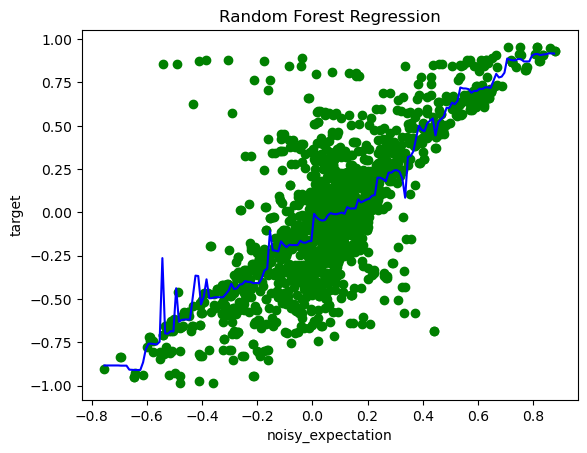

In [11]:
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=5)
rf.fit(pd.DataFrame(df_train['noisy_expectation']), df_train['target'])

X_grid = np.arange(min(df_train['noisy_expectation']), max(df_train['noisy_expectation']), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(df_train['noisy_expectation'], df_train['target'], color = 'green')
plt.plot(X_grid, rf.predict(X_grid), color = 'blue')
plt.title('Random Forest Regression')
plt.xlabel('noisy_expectation')
plt.ylabel('target')
plt.show()

# Plot errors

Text(0.5, 1.0, 'Correlation Matrix')

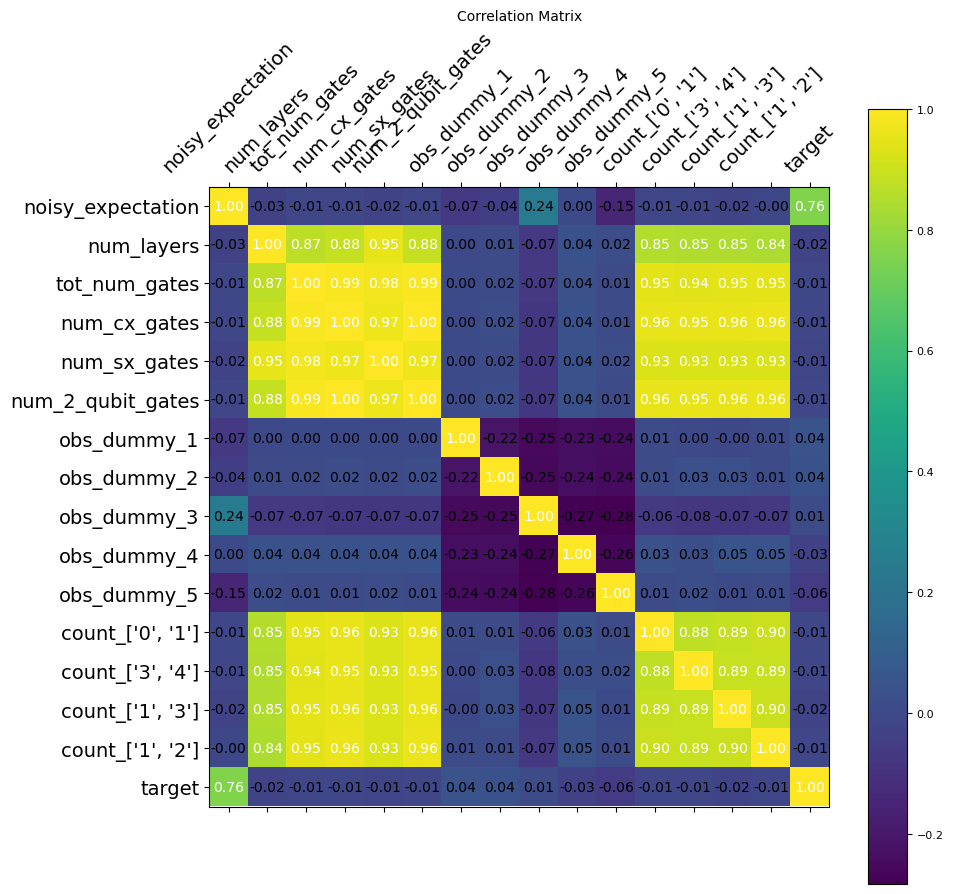

In [12]:
f = plt.figure(figsize=(10, 10))
plt.matshow(df_train.corr(), fignum=f.number)
for (i, j), val in np.ndenumerate(df_train.corr().values):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')
plt.xticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=10)

In [13]:
MSE_unmit = mean_squared_error(df_eval['target'], df_eval['noisy_expectation'])
R2_unmit = r2_score(df_eval['target'], df_eval['noisy_expectation'])
MSE_unmit

0.07702756574336607

C:\Users\malte\AppData\Local\Temp\ipykernel_9400\299617902.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=90, ha='center')


Text(0.5, 1.0, 'MSE KFold values of models folded')

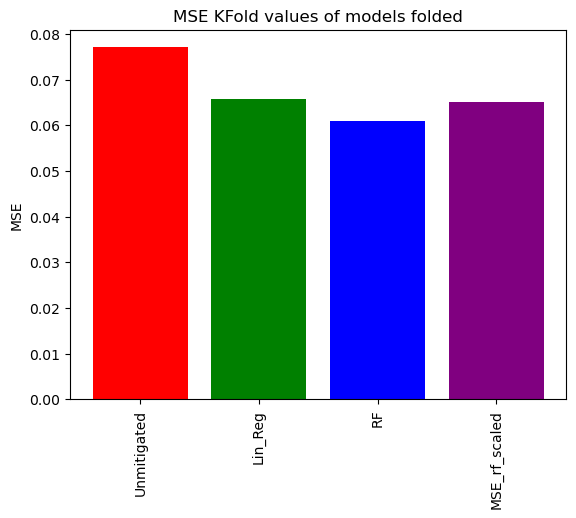

In [14]:
fig, ax = plt.subplots()

models = ['Unmitigated', 'Lin_Reg', 'RF', 'MSE_rf_scaled']
MSE_error =[MSE_unmit, MSE_LR_kf, MSE_rf_kf, MSE_rf_scaled_kf]
colors_kf = ['red', 'green', 'blue', 'purple']

ax.bar(models, MSE_error, color = colors_kf)
ax.set_xticklabels(models, rotation=90, ha='center')
ax.set_ylabel('MSE')
ax.set_title('MSE KFold values of models folded')

C:\Users\malte\AppData\Local\Temp\ipykernel_9400\2424639200.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=90, ha='center')


Text(0.5, 1.0, 'MSE Evaluation values of models folded')

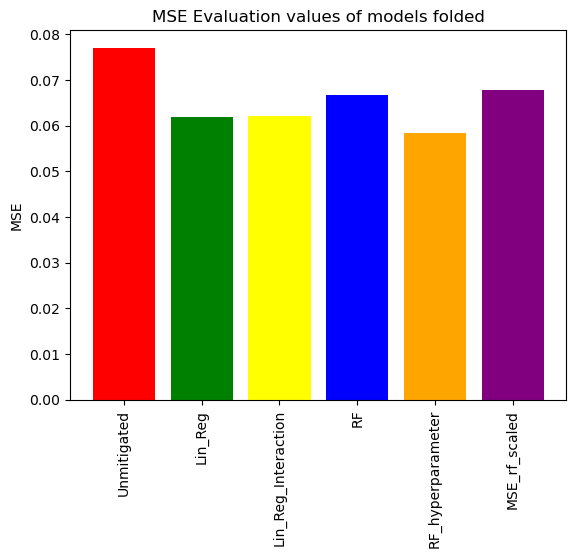

In [15]:
fig, ax = plt.subplots()

models = ['Unmitigated', 'Lin_Reg', 'Lin_Reg_Interaction', 'RF', 'RF_hyperparameter', 'MSE_rf_scaled']
MSE_error =[MSE_unmit, MSE_LR_eval, MSE_lri_eval, MSE_rf_eval, MSE_rf_hyperparam_eval, MSE_rf_scaled_eval]
colors = ['red', 'green', 'yellow', 'blue', 'orange', 'purple']

ax.bar(models, MSE_error, color = colors)
ax.set_xticklabels(models, rotation=90, ha='center')
ax.set_ylabel('MSE')
ax.set_title('MSE Evaluation values of models folded')

C:\Users\malte\AppData\Local\Temp\ipykernel_9400\275364541.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=90, ha='center')


Text(0.5, 1.0, 'R2 KFold values of models folded')

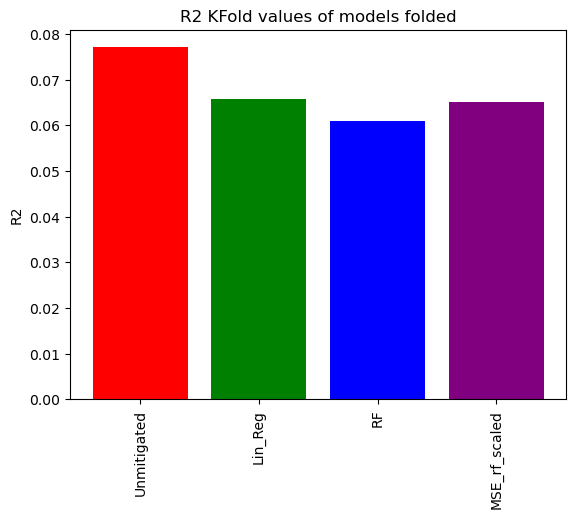

In [16]:
fig, ax = plt.subplots()

models = ['Unmitigated', 'Lin_Reg', 'RF', 'MSE_rf_scaled']
R2_error =[MSE_unmit, MSE_LR_kf, MSE_rf_kf, MSE_rf_scaled_kf]

ax.bar(models, R2_error, color = colors_kf)
ax.set_xticklabels(models, rotation=90, ha='center')
ax.set_ylabel('R2')
ax.set_title('R2 KFold values of models folded')

C:\Users\malte\AppData\Local\Temp\ipykernel_9400\2521120891.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=90, ha='center')


Text(0.5, 1.0, 'R2 Evaluation values of models folded')

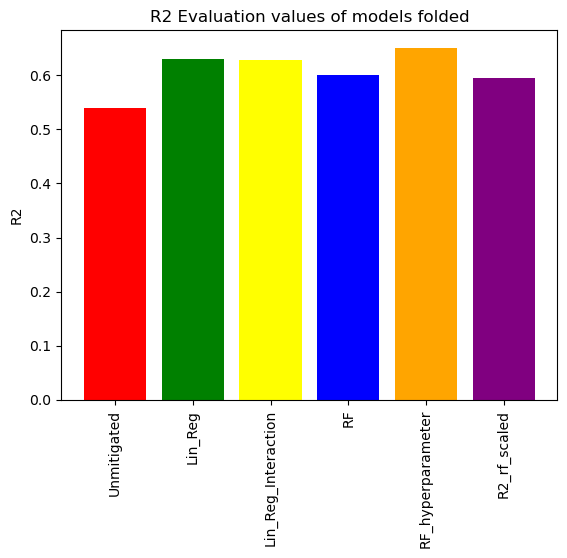

In [17]:
fig, ax = plt.subplots()

models = ['Unmitigated', 'Lin_Reg', 'Lin_Reg_Interaction', 'RF', 'RF_hyperparameter', 'R2_rf_scaled']
R2_error =[R2_unmit, R2_LR_eval, R2_lri_eval, R2_rf_eval, R2_rf_hyperparam_eval, R2_rf_scaled_eval]

ax.bar(models, R2_error, color = colors)
ax.set_xticklabels(models, rotation=90, ha='center')
ax.set_ylabel('R2')
ax.set_title('R2 Evaluation values of models folded')